# Classifier Notebook
---
## Summary

### This notebook aims to answer:
- What methods can be used to address the class imbalances
- What impact do the methods have

### SETUP CELL
- Import the libraries that are going to be used
- Read in the dataset
- Set the random state
- Validate that the dataset has been read in correctly

In [1]:
#SETUP CELL
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras


#Read in csv to datafram
f = 'Dataset/combined.csv'
df = pd.read_csv(f, index_col=False)

#Set random state - makes it reproducable
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

#Validate the read
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16173222 entries, 0 to 16173221
Data columns (total 79 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   Protocol           int64  
 2   Flow Duration      int64  
 3   Tot Fwd Pkts       int64  
 4   Tot Bwd Pkts       int64  
 5   TotLen Fwd Pkts    float64
 6   TotLen Bwd Pkts    float64
 7   Fwd Pkt Len Max    float64
 8   Fwd Pkt Len Min    float64
 9   Fwd Pkt Len Mean   float64
 10  Fwd Pkt Len Std    float64
 11  Bwd Pkt Len Max    float64
 12  Bwd Pkt Len Min    float64
 13  Bwd Pkt Len Mean   float64
 14  Bwd Pkt Len Std    float64
 15  Flow Byts/s        float64
 16  Flow Pkts/s        float64
 17  Flow IAT Mean      float64
 18  Flow IAT Std       float64
 19  Flow IAT Max       float64
 20  Flow IAT Min       float64
 21  Fwd IAT Tot        float64
 22  Fwd IAT Mean       float64
 23  Fwd IAT Std        float64
 24  Fwd IAT Max        float64
 25  Fwd IAT Min     

### Handle inf, reorder the dataset
Inf values cannot be processed by the scaler that will be used later. The order of the dataset also need to be shuffled

In [2]:
#drop inf
df = df.replace([np.inf, -np.inf], np.nan).dropna()

#Randomise the order of the dataset, drop the original index
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

### Features and Targets
- Split the features and targets 
- Print the original label and the encoded label for clarity
- One hot encode the targets

In [3]:
# Separate the features and labels
features = df.drop(['Label'], axis=1)
labels_factorize = pd.factorize(df.Label)
df['Label_factorize'] = labels_factorize[0]

# Print the class count and the encoded labeled 
print(df['Label'].value_counts())
print(df['Label_factorize'].value_counts())

# One Hot Endcoded
targets = pd.get_dummies(df['Label'], prefix="type")

Benign                      13390249
DDOS attack-HOIC              686012
DDoS attacks-LOIC-HTTP        576191
DoS attacks-Hulk              461912
Bot                           286191
FTP-BruteForce                193354
SSH-Bruteforce                187589
Infilteration                 160639
DoS attacks-SlowHTTPTest      139890
DoS attacks-GoldenEye          41508
DoS attacks-Slowloris          10990
DDOS attack-LOIC-UDP            1730
Brute Force -Web                 611
Brute Force -XSS                 230
SQL Injection                     87
Name: Label, dtype: int64
0     13390249
3       686012
6       576191
8       461912
1       286191
9       193354
4       187589
5       160639
2       139890
7        41508
12       10990
11        1730
10         611
13         230
14          87
Name: Label_factorize, dtype: int64


### Train Test Split
- Split the data into train test 80:20
- Split the train set again into train and val 80:20
- convert into numpy arrays

In [4]:
#train test split
# Use a utility from sklearn to split and shuffle dataset.
train_features, test_features, train_labels, test_labels = train_test_split(features, targets, test_size=0.2, random_state=RANDOM_STATE)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.2, random_state=RANDOM_STATE)

# Form np arrays of labels and features.
train_labels = train_labels.to_numpy()
val_labels = val_labels.to_numpy()
test_labels = test_labels.to_numpy()

train_features = np.array(train_features)
val_features = np.array(val_features)
test_features = np.array(test_features)

### Scale the data
- Scale and transform the data
- range -5, to 5
- clip outliers

In [5]:
# Scale data
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# Clip outliers
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

# Validate label and feature shapes are the same 
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (10327796, 15)
Validation labels shape: (2581950, 15)
Test labels shape: (3227437, 15)
Training features shape: (10327796, 78)
Validation features shape: (2581950, 78)
Test features shape: (3227437, 78)


## Classifiers
---
### Define Model Structure
- Input layer = len features
- 3 Dense layers of 64 nodes
- 3 Dropout layers inbetween each Dense layer
- Output layer = num classes

In [6]:
#Metrics used to track training 
METRICS = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'), 
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.CategoricalAccuracy(name='acc'),
  keras.metrics.AUC(name='auc'),
  keras.metrics.AUC(name='prc', curve='PR')
]

#Define the model
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(64, activation='relu',
        input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dropout(0.5),
      #change activation funtion
      keras.layers.Dense(15, activation='softmax',
        bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss='categorical_crossentropy',
      metrics=metrics)

  return model

In [7]:
EPOCHS = 250
BATCH_SIZE = 2048

#stop after tracking the val loss metric
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

## Baseline Model
- Create baseline model
- Used as a control group
- All methods to deal with imbalances are compared to the baseline model

In [8]:
model = make_model()

baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose = 1,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels)
)

Epoch 1/250
5043/5043 [==============================] - 38s 7ms/step - loss: 0.1378 - tp: 9875522.0000 - fp: 260903.0000 - tn: 144328160.0000 - fn: 452274.0000 - precision: 0.9743 - recall: 0.9562 - acc: 0.9643 - auc: 0.9974 - prc: 0.9837 - val_loss: 0.0720 - val_tp: 2530291.0000 - val_fp: 50763.0000 - val_tn: 36096536.0000 - val_fn: 51659.0000 - val_precision: 0.9803 - val_recall: 0.9800 - val_acc: 0.9801 - val_auc: 0.9995 - val_prc: 0.9934
Epoch 2/250
5043/5043 [==============================] - 33s 7ms/step - loss: 0.0801 - tp: 10097041.0000 - fp: 210729.0000 - tn: 144378656.0000 - fn: 230755.0000 - precision: 0.9796 - recall: 0.9777 - acc: 0.9786 - auc: 0.9988 - prc: 0.9902 - val_loss: 0.0679 - val_tp: 2531537.0000 - val_fp: 50336.0000 - val_tn: 36096936.0000 - val_fn: 50413.0000 - val_precision: 0.9805 - val_recall: 0.9805 - val_acc: 0.9805 - val_auc: 0.9994 - val_prc: 0.9938
Epoch 3/250
5043/5043 [==============================] - 34s 7ms/step - loss: 0.0767 - tp: 10107186.0000 

In [9]:
baseline_predictions = model.predict(test_features,
                                  batch_size=BATCH_SIZE)
test_labels_argmax = np.argmax(test_labels, axis=1)
baseline_predictions_argmax = np.argmax(baseline_predictions, axis=1)
print(classification_report(test_labels_argmax, 
                            baseline_predictions_argmax))

e:\Workspace\dsVenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Workspace\dsVenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99   2677442
           1       1.00      1.00      1.00     57196
           2       0.00      0.00      0.00       134
           3       0.00      0.00      0.00        59
           4       1.00      1.00      1.00    137574
           5       0.00      0.00      0.00       354
           6       0.99      0.99      0.99    115369
           7       0.99      0.99      0.99      8185
           8       1.00      1.00      1.00     92425
           9       0.65      0.55      0.60     28002
          10       0.94      0.98      0.96      2195
          11       0.71      0.79      0.75     38964
          12       0.41      0.00      0.01     31976
          13       0.00      0.00      0.00        16
          14       1.00      1.00      1.00     37546

    accuracy                           0.98   3227437
   macro avg       0.65      0.62      0.62   3227437
weighted avg       0.98   

e:\Workspace\dsVenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Baseline Observation 1
- Model performed well
- Clear room for improvement in classes 2, 3, 5, 12, 13
- DoS attacks-SlowHTTPTest, DDOS attack-HOIC, Infilteration, DoS attacks-Slowloris, Brute Force -XSS

In [10]:
print(labels_factorize[1])

Index(['Benign', 'Bot', 'DoS attacks-SlowHTTPTest', 'DDOS attack-HOIC',
       'SSH-Bruteforce', 'Infilteration', 'DDoS attacks-LOIC-HTTP',
       'DoS attacks-GoldenEye', 'DoS attacks-Hulk', 'FTP-BruteForce',
       'Brute Force -Web', 'DDOS attack-LOIC-UDP', 'DoS attacks-Slowloris',
       'Brute Force -XSS', 'SQL Injection'],
      dtype='object')


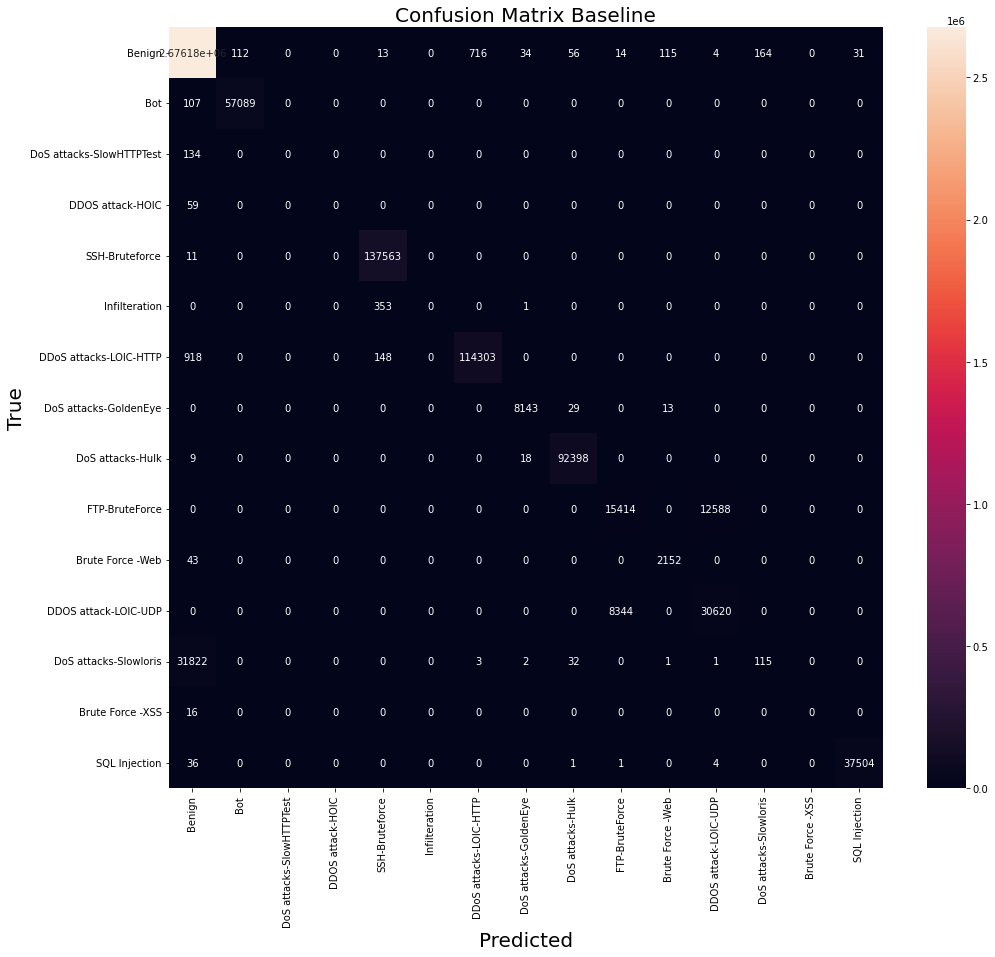

In [11]:
cm = confusion_matrix(test_labels_argmax, 
                        baseline_predictions_argmax)

## Get Class Labels
labels = labels_factorize[1]
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix Baseline', fontsize=20)

plt.savefig('baseline.png')
plt.show()

### Baseline Observation 2
- None of the classes mention in Baseline Observation 1 were correctly identified

## Weighted Model
- Compute the class weights
- Give the model the class weights at fit

### Compute Class weights
- Use sklearn function to compute the weights

In [12]:
#import
from sklearn.utils.class_weight import compute_class_weight

#convert targets to np.array
targets = np.array(targets)

#format the targets
class_series = np.argmax(targets, axis=1)
class_labels = np.unique(class_series)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)

#create dictionary
class_weights_dict = dict(zip(class_labels, class_weights))

### Define Weighted Model
- Same as the baseline model
- Add the calculated class weights

In [13]:
weighted_model = make_model()
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weights_dict
    )

Epoch 1/250
5043/5043 [==============================] - 37s 7ms/step - loss: 1.4018 - tp: 4602391.0000 - fp: 2396380.0000 - tn: 178340192.0000 - fn: 8307355.0000 - precision: 0.6576 - recall: 0.3565 - acc: 0.4465 - auc: 0.9294 - prc: 0.5877 - val_loss: 1.0789 - val_tp: 488756.0000 - val_fp: 1484585.0000 - val_tn: 34662672.0000 - val_fn: 2093194.0000 - val_precision: 0.2477 - val_recall: 0.1893 - val_acc: 0.2156 - val_auc: 0.9473 - val_prc: 0.4776
Epoch 2/250
5043/5043 [==============================] - 32s 6ms/step - loss: 0.8982 - tp: 3608781.0000 - fp: 3153898.0000 - tn: 141435024.0000 - fn: 6719015.0000 - precision: 0.5336 - recall: 0.3494 - acc: 0.4131 - auc: 0.9432 - prc: 0.5243 - val_loss: 0.9687 - val_tp: 559288.0000 - val_fp: 1614738.0000 - val_tn: 34532584.0000 - val_fn: 2022662.0000 - val_precision: 0.2573 - val_recall: 0.2166 - val_acc: 0.2277 - val_auc: 0.9486 - val_prc: 0.4736
Epoch 3/250
5043/5043 [==============================] - 32s 6ms/step - loss: 0.7687 - tp: 41334

In [14]:
weighted_predictions = weighted_model.predict(test_features,
                                  batch_size=BATCH_SIZE)
weighted_predictions_argmax = np.argmax(weighted_predictions, axis=1)
print(classification_report(test_labels_argmax, 
                            weighted_predictions_argmax))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91   2677442
           1       0.89      1.00      0.94     57196
           2       0.01      0.41      0.01       134
           3       0.00      0.56      0.01        59
           4       1.00      1.00      1.00    137574
           5       0.69      1.00      0.81       354
           6       0.88      0.94      0.91    115369
           7       0.89      0.84      0.86      8185
           8       0.99      1.00      0.99     92425
           9       0.52      0.99      0.68     28002
          10       0.22      1.00      0.37      2195
          11       0.98      0.33      0.50     38964
          12       0.02      0.10      0.03     31976
          13       0.00      0.94      0.00        16
          14       0.99      1.00      1.00     37546

    accuracy                           0.84   3227437
   macro avg       0.60      0.80      0.60   3227437
weighted avg       0.97   

#### Weighted Observation 1
- Improvements in the identified classes
- The important metrics are the macro avg
- Surprising decline in Precision and F1-Score
- Significant improvement to recall

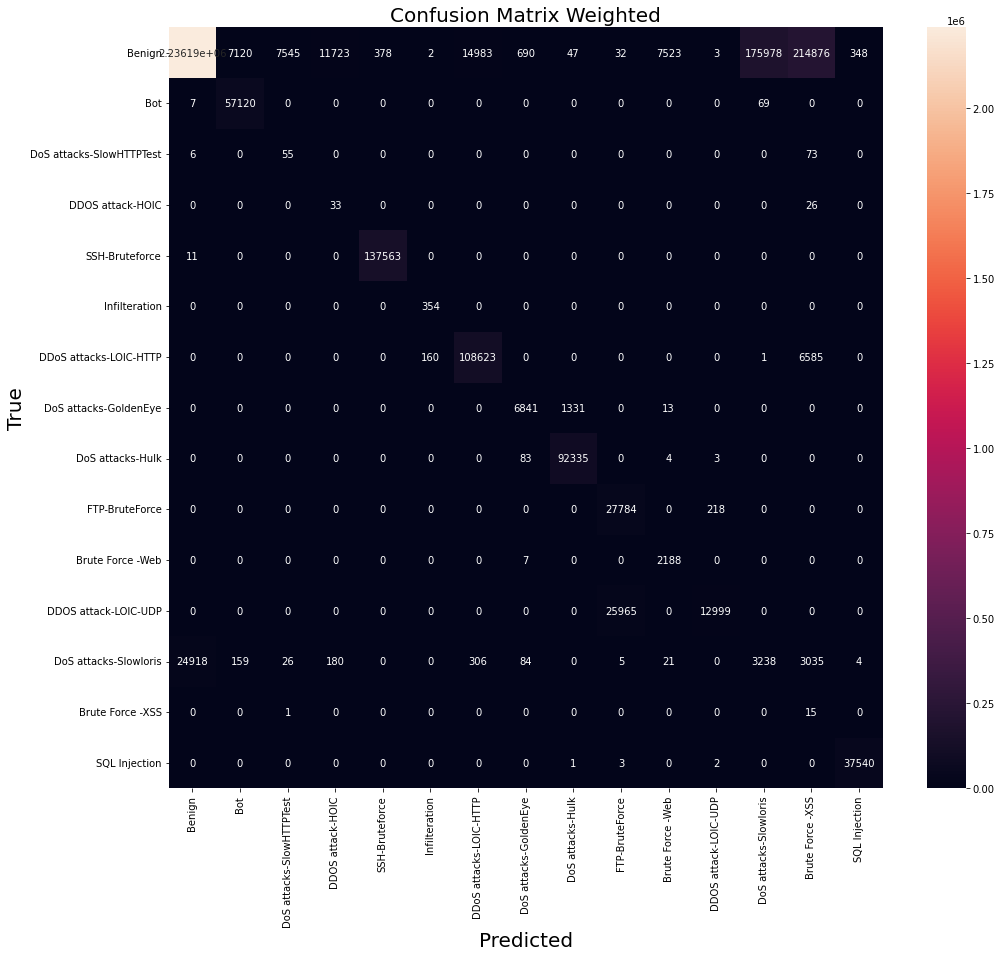

In [15]:
cm = confusion_matrix(test_labels_argmax, 
                        weighted_predictions_argmax)


# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix Weighted', fontsize=20)

plt.savefig('weighted.png')
plt.show()

#### Weighted Observation 2
- 15/16 Brute Force XSS were correctly identified in comparison to the 0 correctly identified by the baseline model
- Less of class 2 and 3 were identified as Benign traffic

## Resample Model
- Resample the classes identified in Baseline Observation 1 with SMOTE
- Only resample the training set

In [16]:
train_labels_arg = np.argmax(train_labels, axis=1)
unique, counts = np.unique(train_labels_arg, return_counts=True)
dict(zip(unique, counts))

{0: 8569998,
 1: 183551,
 2: 383,
 3: 137,
 4: 438514,
 5: 1066,
 6: 368267,
 7: 26696,
 8: 295553,
 9: 89619,
 10: 7028,
 11: 123779,
 12: 102971,
 13: 55,
 14: 120179}

### Resample Observation 1
- Class 2, 3, 5, 10, 13 are under represented
- They will be traget and oversampled to 20,000 instances

In [17]:
strat = {
        2: 20000,
        3: 20000,
        5: 20000,
        10: 20000,
        13: 20000}

### Oversample
- Import SMOTE
- Oversampled using the identified strategy

In [18]:
#Import
from imblearn.over_sampling import SMOTE

#oversampler
oversample = SMOTE(sampling_strategy=strat, random_state=RANDOM_STATE)

#apply oversampler to train dataset
train_features_re, train_labels_re = oversample.fit_resample(train_features, train_labels)

### Resmpled Model
- Same as base line
- Used the resampled training set

In [19]:
resample_model = make_model()
resample_history = resample_model.fit(
    train_features_re,
    train_labels_re,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels)
    )

Epoch 1/250
5088/5088 [==============================] - 37s 7ms/step - loss: 0.1836 - tp: 12039665.0000 - fp: 506088.0000 - tn: 181509472.0000 - fn: 961412.0000 - precision: 0.9597 - recall: 0.9261 - acc: 0.9386 - auc: 0.9954 - prc: 0.9668 - val_loss: 0.0739 - val_tp: 2529850.0000 - val_fp: 50727.0000 - val_tn: 36096572.0000 - val_fn: 52100.0000 - val_precision: 0.9803 - val_recall: 0.9798 - val_acc: 0.9802 - val_auc: 0.9995 - val_prc: 0.9934
Epoch 2/250
5088/5088 [==============================] - 31s 6ms/step - loss: 0.1022 - tp: 10100864.0000 - fp: 255007.0000 - tn: 145612688.0000 - fn: 318263.0000 - precision: 0.9754 - recall: 0.9695 - acc: 0.9721 - auc: 0.9985 - prc: 0.9886 - val_loss: 0.0677 - val_tp: 2531796.0000 - val_fp: 48567.0000 - val_tn: 36098764.0000 - val_fn: 50154.0000 - val_precision: 0.9812 - val_recall: 0.9806 - val_acc: 0.9811 - val_auc: 0.9995 - val_prc: 0.9935
Epoch 3/250
5088/5088 [==============================] - 31s 6ms/step - loss: 0.0945 - tp: 10121449.0000

In [20]:
resample_predictions = resample_model.predict(test_features,
                                  batch_size=BATCH_SIZE)
resample_predictions_argmax = np.argmax(resample_predictions, axis=1)
print(classification_report(test_labels_argmax, 
                            resample_predictions_argmax))

e:\Workspace\dsVenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Workspace\dsVenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99   2677442
           1       1.00      1.00      1.00     57196
           2       0.08      0.62      0.14       134
           3       0.94      0.56      0.70        59
           4       1.00      1.00      1.00    137574
           5       0.69      1.00      0.81       354
           6       0.99      0.99      0.99    115369
           7       1.00      0.99      0.99      8185
           8       1.00      1.00      1.00     92425
           9       0.52      0.99      0.68     28002
          10       0.95      0.99      0.97      2195
          11       0.98      0.33      0.50     38964
          12       0.00      0.00      0.00     31976
          13       0.04      0.38      0.07        16
          14       1.00      1.00      1.00     37546

    accuracy                           0.98   3227437
   macro avg       0.74      0.79      0.72   3227437
weighted avg       0.98   

e:\Workspace\dsVenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Resampled Observation 2
- Significant improvement to all macro avg score
- Weighted avg all have the same score as baseline
- Class 12 is still performing poorly
- Class 12 isn't under represented

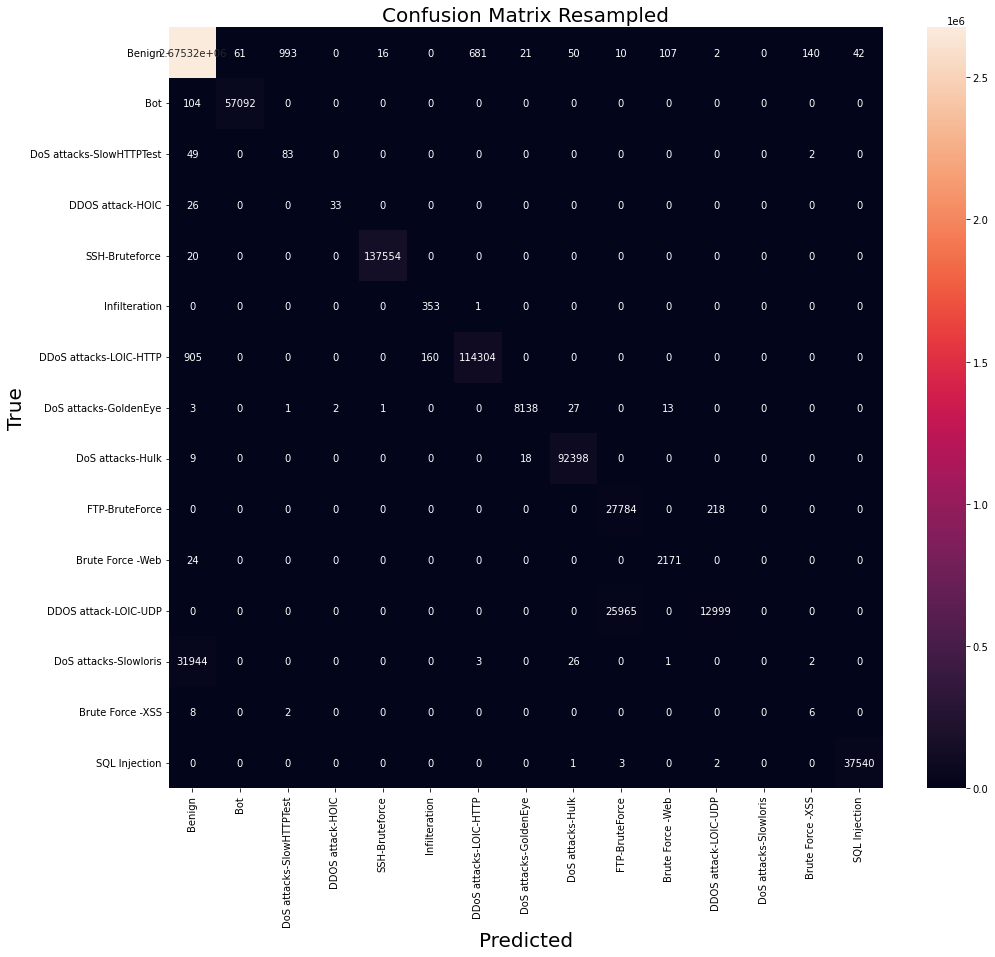

In [21]:
cm = confusion_matrix(test_labels_argmax, 
                        resample_predictions_argmax)


# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix Resampled', fontsize=20)

plt.savefig('resample.png')
plt.show()

### Resampled Observation 3
- There must be a strong similarity in pattern between Dos attacks-Sloworis and Benign traffic
- Despite the weighting and resampling this class repeatedly performs poorly

## Further Weighted Opimisation
--- 
### Learning Rate
- See the effects of significantly increasing LR
- See the effects of singnificantly decreasing LR

### Decrease learning rate
- 1e-7

In [22]:
def make_model_2(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
    #change activation function
      keras.layers.Dense(64, activation='relu',
        input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dropout(0.5),
      #change activation funtion
      keras.layers.Dense(15, activation='softmax',
        bias_initializer=output_bias),
  ])

  model.compile(
    #change learning rate
      optimizer=keras.optimizers.Adam(learning_rate=1e-7),
      loss='categorical_crossentropy',
      metrics=metrics)

  return model

In [23]:
weighted_model_slow = make_model_2()
weighted_history_slow = weighted_model_slow.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weights_dict
    )

Epoch 1/250
5043/5043 [==============================] - 37s 7ms/step - loss: 3.1913 - tp: 2552488.0000 - fp: 217275.0000 - tn: 180519472.0000 - fn: 10357258.0000 - precision: 0.9216 - recall: 0.1977 - acc: 0.2992 - auc: 0.7782 - prc: 0.3548 - val_loss: 2.4410 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 36147300.0000 - val_fn: 2581950.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.1891 - val_auc: 0.7988 - val_prc: 0.2043
Epoch 2/250
5043/5043 [==============================] - 31s 6ms/step - loss: 3.1873 - tp: 20172.0000 - fp: 167196.0000 - tn: 144421696.0000 - fn: 10307624.0000 - precision: 0.1077 - recall: 0.0020 - acc: 0.1286 - auc: 0.6571 - prc: 0.1074 - val_loss: 2.4418 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 36147300.0000 - val_fn: 2581950.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.1884 - val_auc: 0.7986 - val_prc: 0.2041
Epoch 3/250
5043/5043 [==============================] - 32s 6ms/step - loss: 3.1635 - t

In [24]:
weighted_predictions_slow = weighted_model_slow.predict(test_features,
                                  batch_size=BATCH_SIZE)
weighted_predictions_slow_argmax = np.argmax(weighted_predictions_slow, axis=1)
print(classification_report(test_labels_argmax, 
                            weighted_predictions_slow_argmax))

e:\Workspace\dsVenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Workspace\dsVenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.83      0.23      0.36   2677442
           1       0.00      0.00      0.00     57196
           2       0.00      0.00      0.00       134
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00    137574
           5       0.00      0.00      0.00       354
           6       0.00      0.00      0.00    115369
           7       0.00      0.11      0.01      8185
           8       0.00      0.00      0.00     92425
           9       0.00      0.00      0.00     28002
          10       0.00      0.27      0.00      2195
          11       0.00      0.00      0.00     38964
          12       0.00      0.00      0.00     31976
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00     37546

    accuracy                           0.19   3227437
   macro avg       0.06      0.04      0.02   3227437
weighted avg       0.69   

e:\Workspace\dsVenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


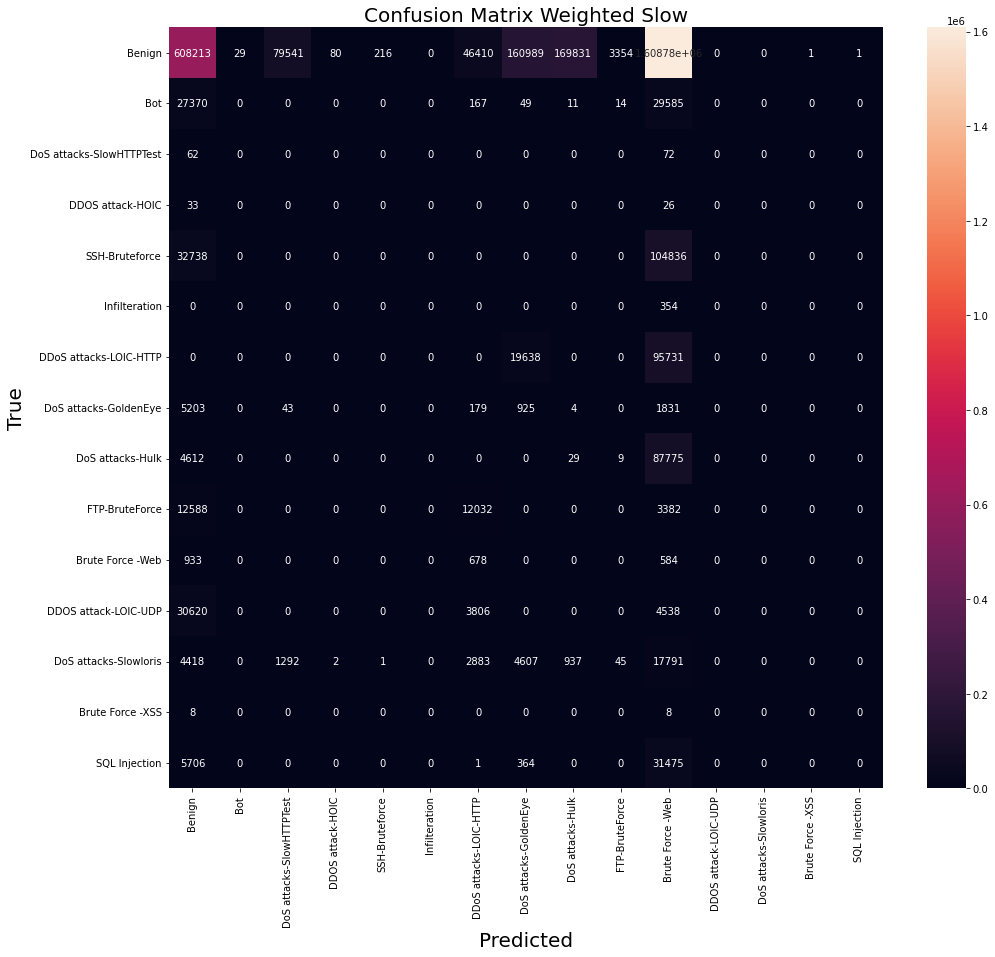

In [25]:
cm = confusion_matrix(test_labels_argmax, 
                        weighted_predictions_slow_argmax)


# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix Weighted Slow', fontsize=20)

plt.savefig('weighted-slow.png')
plt.show()

### Slow Observations
- Significantly decreased performance of model
- Majority of traffic identified as Brute Force

### Increase learning rate
- 1e-1

In [26]:
def make_model_3(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
    #change activation function
      keras.layers.Dense(64, activation='relu',
        input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dropout(0.5),
      #change activation funtion
      keras.layers.Dense(15, activation='softmax',
        bias_initializer=output_bias),
  ])

  model.compile(
    #change learning rate
      optimizer=keras.optimizers.Adam(learning_rate=1e-1),
      loss='categorical_crossentropy',
      metrics=metrics)

  return model

In [27]:
weighted_model_fast = make_model_3()
weighted_history_fast = weighted_model_fast.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weights_dict
    )

Epoch 1/250
5043/5043 [==============================] - 38s 7ms/step - loss: 2.7511 - tp: 2772.0000 - fp: 5918.0000 - tn: 180730688.0000 - fn: 12906974.0000 - precision: 0.3190 - recall: 2.1472e-04 - acc: 0.0401 - auc: 0.6015 - prc: 0.0808 - val_loss: 2.8877 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 36147300.0000 - val_fn: 2581950.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 3.6407e-05 - val_auc: 0.5160 - val_prc: 0.0624
Epoch 2/250
5043/5043 [==============================] - 33s 7ms/step - loss: 2.7389 - tp: 4.0000 - fp: 9.0000 - tn: 144589152.0000 - fn: 10327792.0000 - precision: 0.3077 - recall: 3.8730e-07 - acc: 0.0030 - auc: 0.5357 - prc: 0.0651 - val_loss: 2.7201 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 36147300.0000 - val_fn: 2581950.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 3.6407e-05 - val_auc: 0.5277 - val_prc: 0.0633
Epoch 3/250
5043/5043 [==============================] - 33s 7ms/step - loss: 2.7630 -

In [28]:
weighted_predictions_fast = weighted_model_fast.predict(test_features,
                                  batch_size=BATCH_SIZE)
weighted_predictions_fast_argmax = np.argmax(weighted_predictions_fast, axis=1)
print(classification_report(test_labels_argmax, 
                            weighted_predictions_fast_argmax))

e:\Workspace\dsVenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Workspace\dsVenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00   2677442
           1       0.00      0.00      0.00     57196
           2       0.00      0.00      0.00       134
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00    137574
           5       0.00      0.00      0.00       354
           6       0.00      0.00      0.00    115369
           7       0.00      0.00      0.00      8185
           8       0.00      0.00      0.00     92425
           9       0.00      0.00      0.00     28002
          10       0.00      0.00      0.00      2195
          11       0.01      1.00      0.02     38964
          12       0.00      0.00      0.00     31976
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00     37546

    accuracy                           0.01   3227437
   macro avg       0.00      0.07      0.00   3227437
weighted avg       0.00   

e:\Workspace\dsVenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


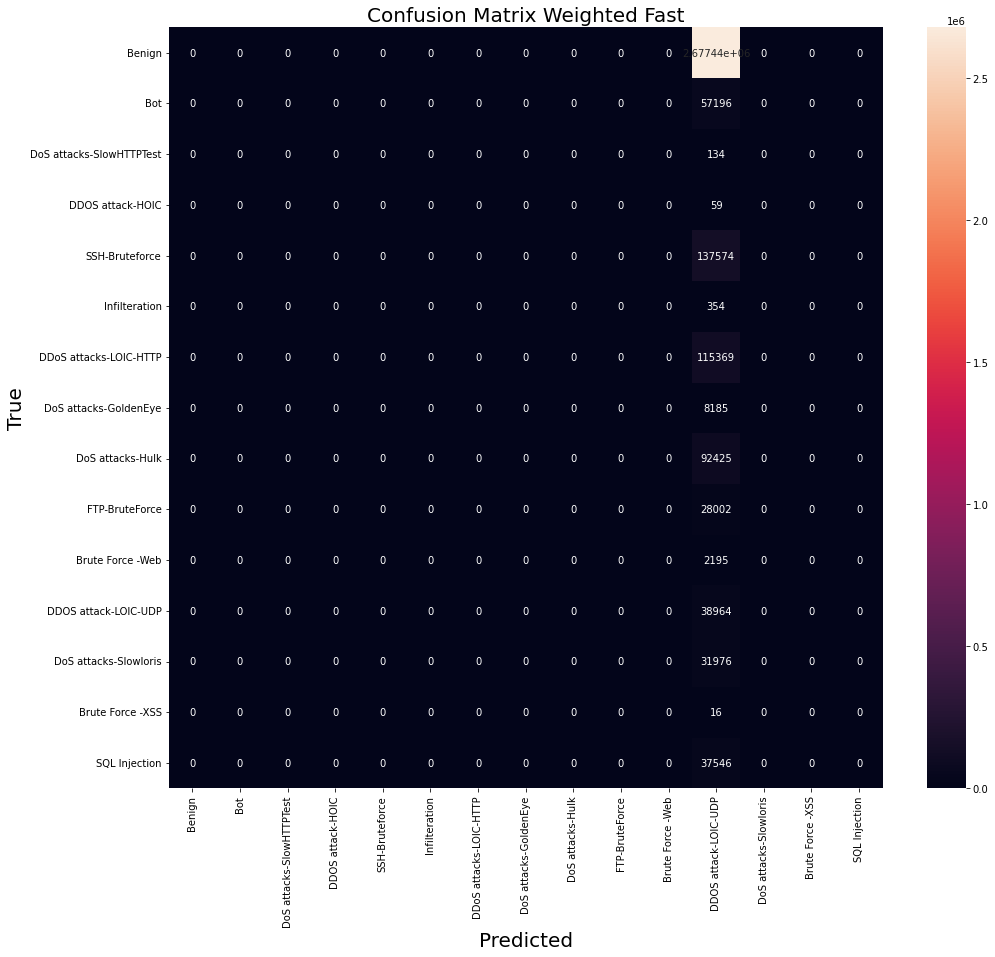

In [29]:
cm = confusion_matrix(test_labels_argmax, 
                        weighted_predictions_fast_argmax)

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix Weighted Fast', fontsize=20)

plt.savefig('weighted-fast.png')
plt.show()

### Fast Learning Rate Observation
- All of the traffic was identified as DDOS attack-LOIC-UDP

In [30]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Validation ' + label)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

### Loss Observations

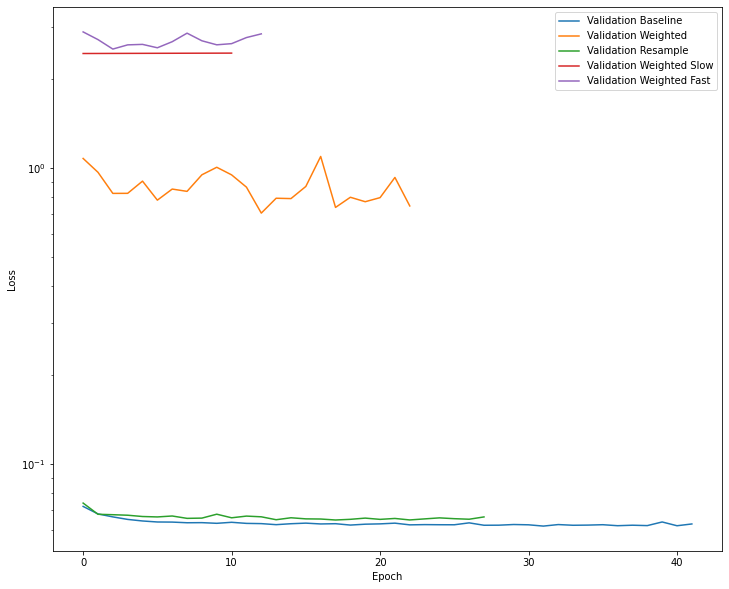

In [33]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
plot_loss(baseline_history, "Baseline", 0)
plot_loss(weighted_history, "Weighted", 1)
plot_loss(resample_history, "Resample", 2)
plot_loss(weighted_history_slow, "Weighted Slow", 3)
plot_loss(weighted_history_fast, "Weighted Fast", 4)
plt.savefig('loss.png')

### Final Observation
- The best model was the model trained with the resampled datasets
- A better observation of loss would be without the early stopping callback 